In [45]:
import os
import biom
import warnings
import numpy as np
import pandas as pd
import qiime2 as q2
from biom import Table
from assets.util import add_taxsplit
from skbio import OrdinationResults
from qiime2.plugins.songbird.actions import multinomial, summarize_paired
from qiime2.plugins.emperor.actions import biplot

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import UpSet
from upsetplot import generate_counts, plot
from upsetplot import from_memberships
from matplotlib_venn import venn2
from matplotlib_venn import (venn3, venn3_circles,
                             venn2_circles)

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.style.use('ggplot')
plt.style.use('tableau-colorblind10')
paper_rc = {'lines.markersize': 5}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

%matplotlib inline



In [46]:
def format_uplot(df):
    df_binary = (df > 0.0).rename(columns=lambda x: x + '>0')
    df = pd.concat([df, df_binary], axis=1)
    index_ = df.index
    df = df.set_index(list(df_binary.columns))
    df['taxa'] = index_
    return df


phylum


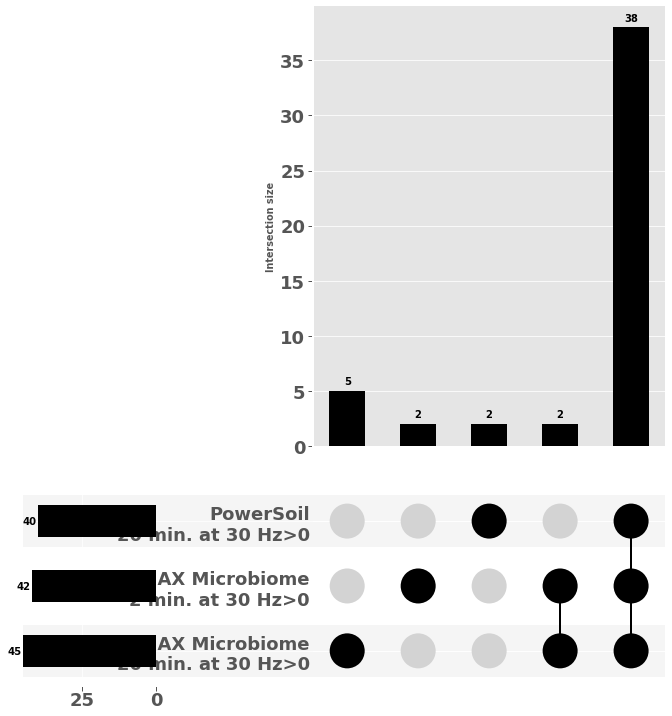

class


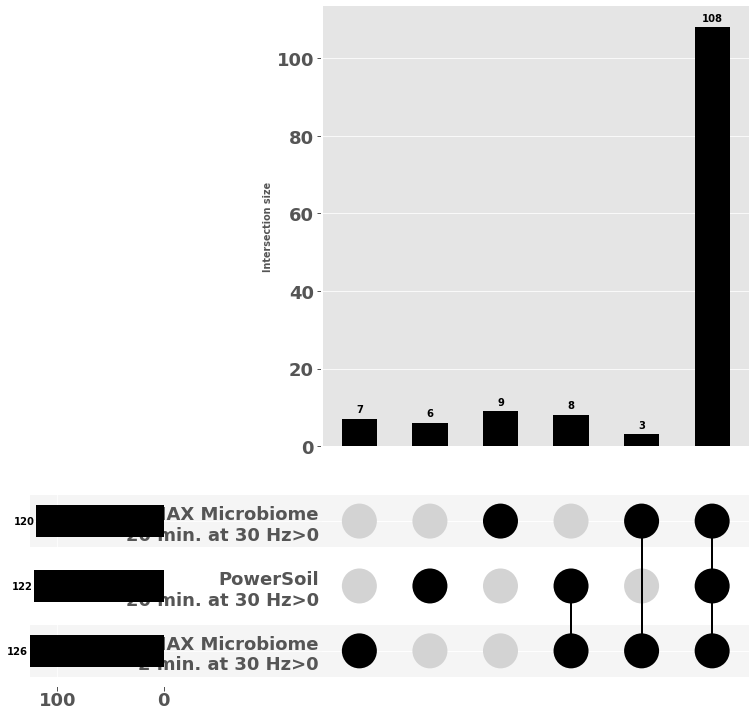

order


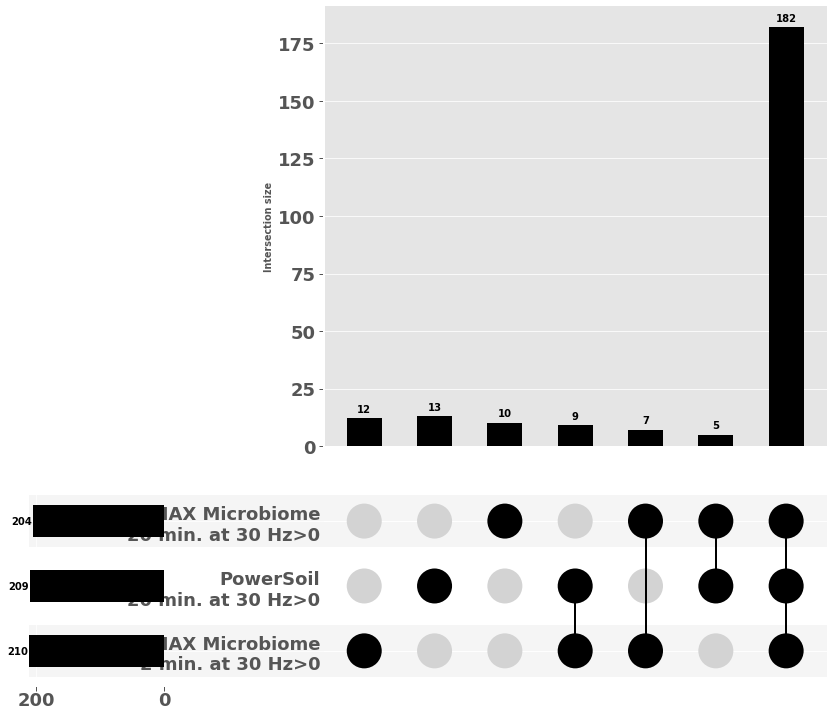

family


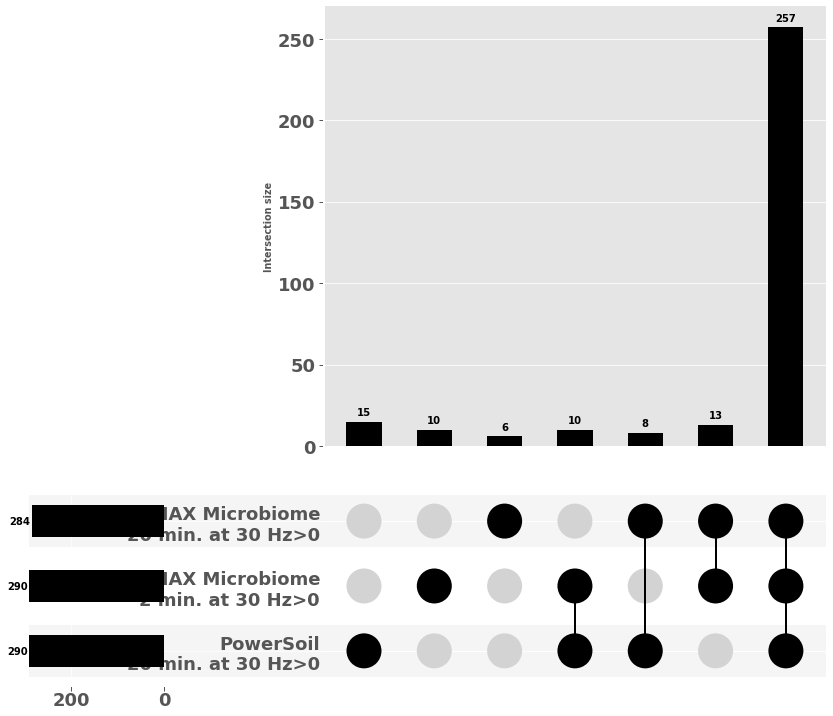

genus


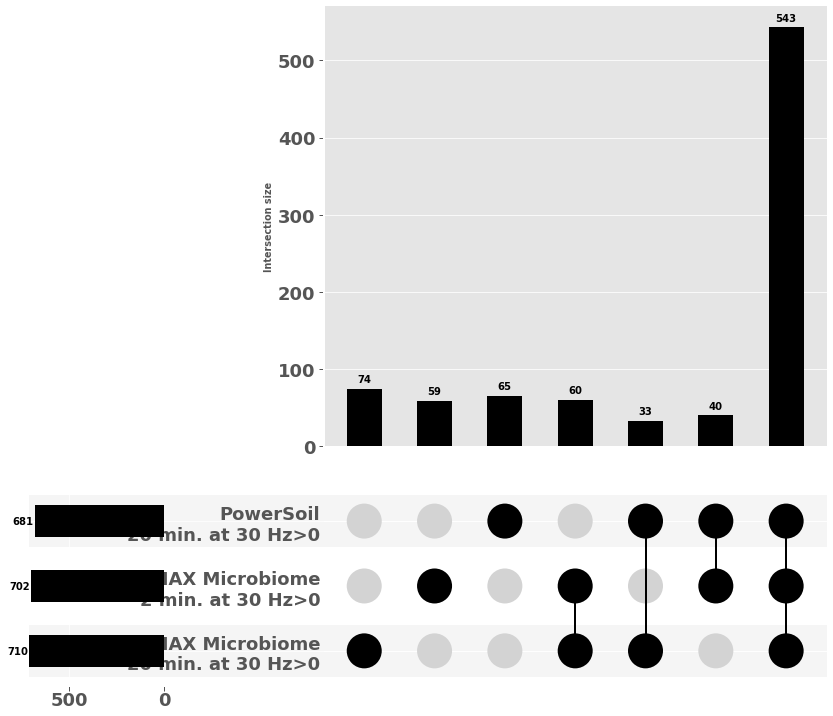

species


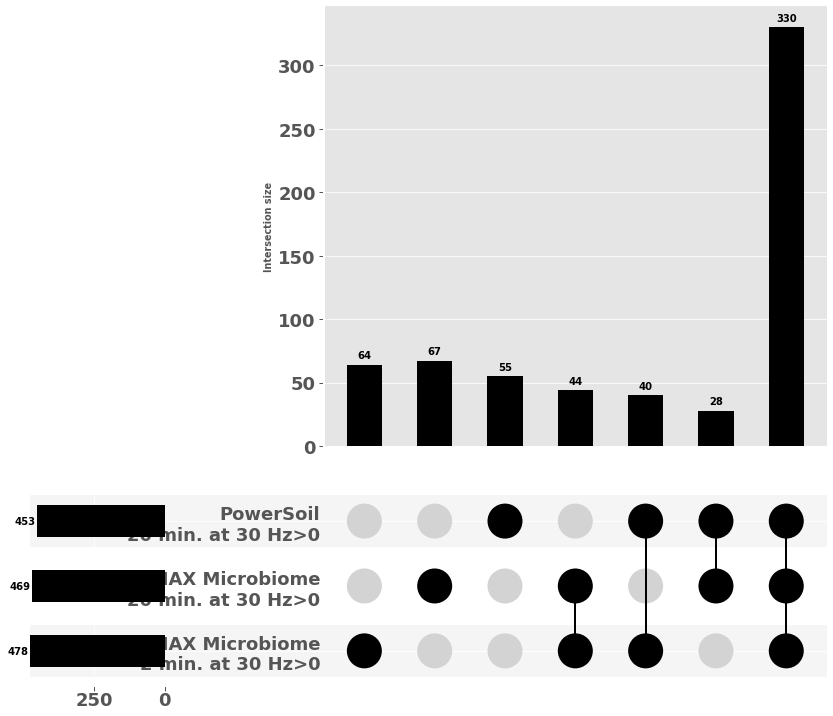

class


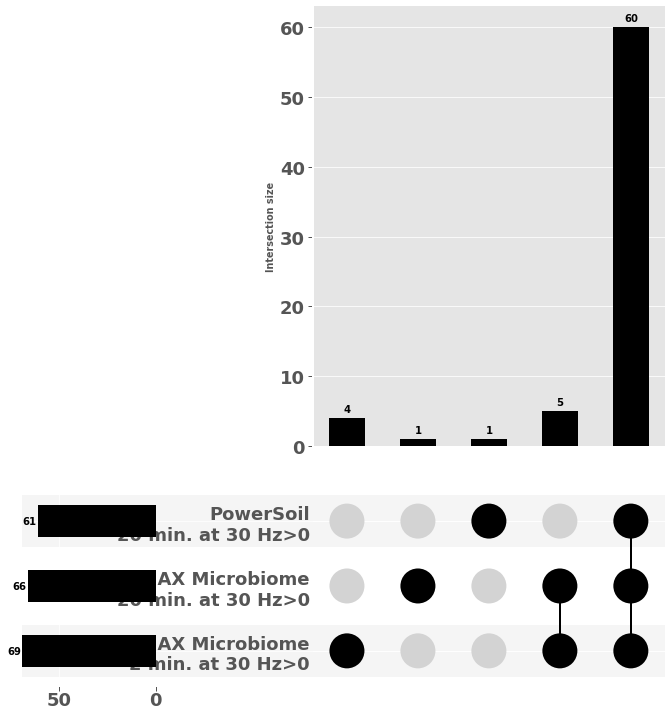

order


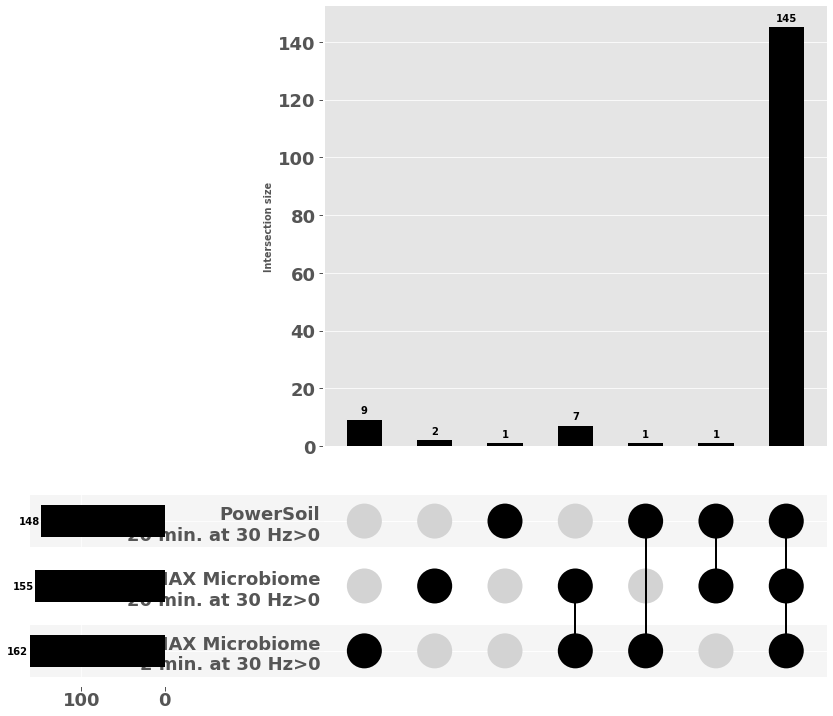

family


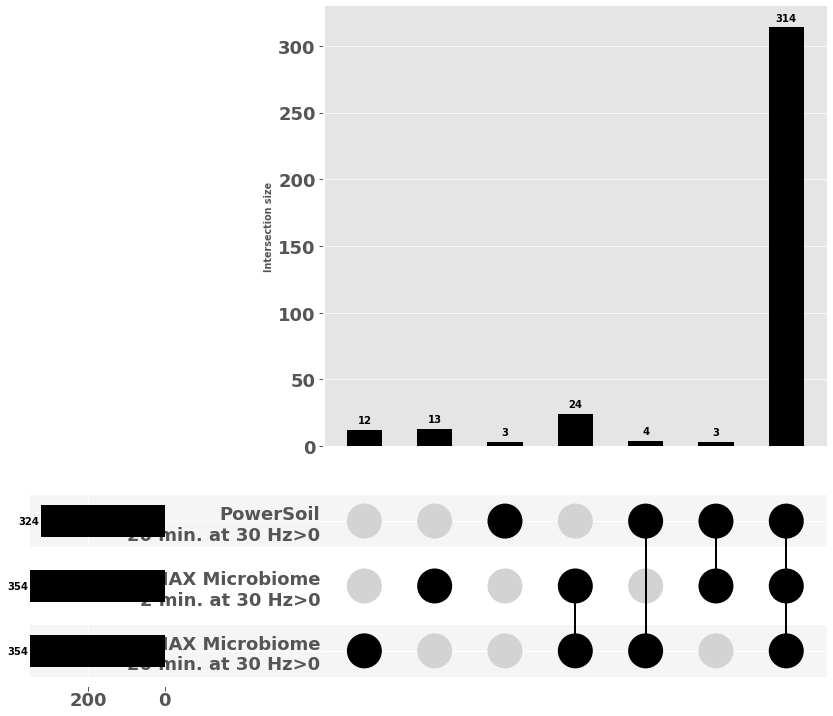

genus


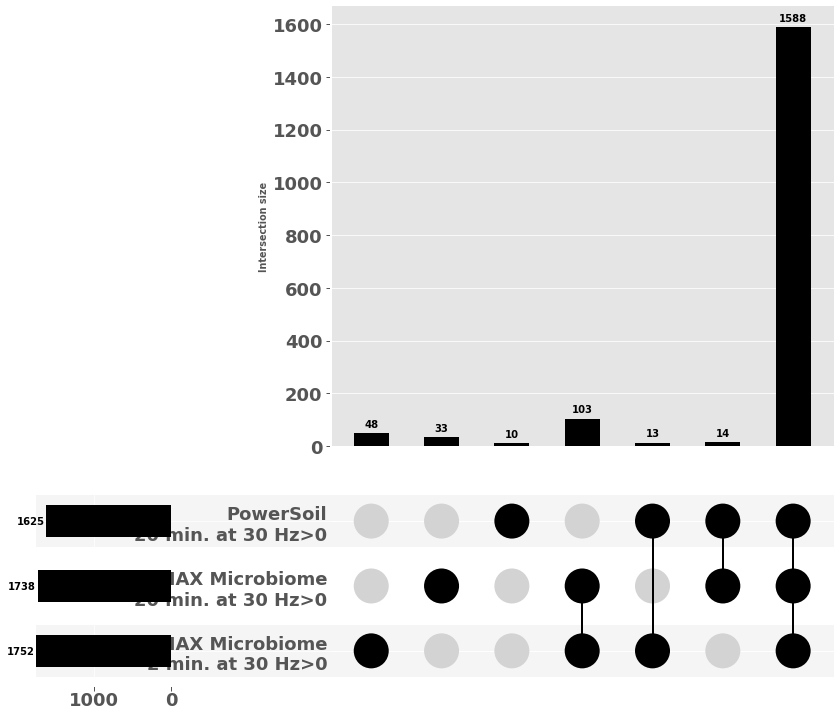

species


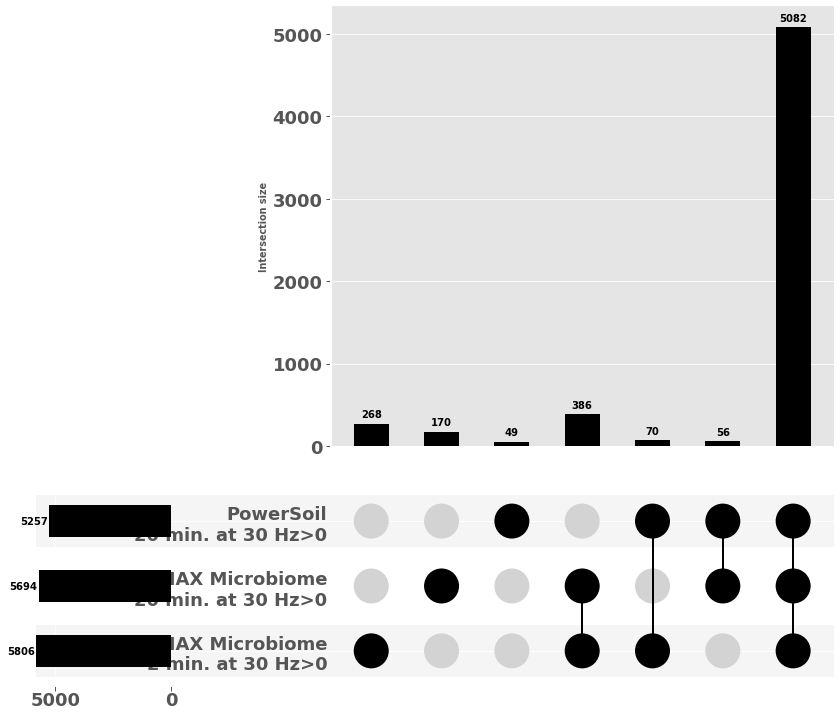

phylum


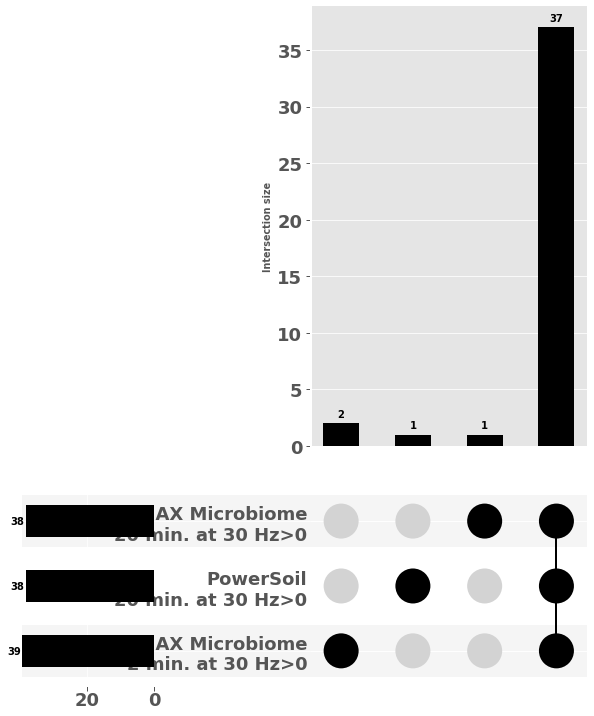

class


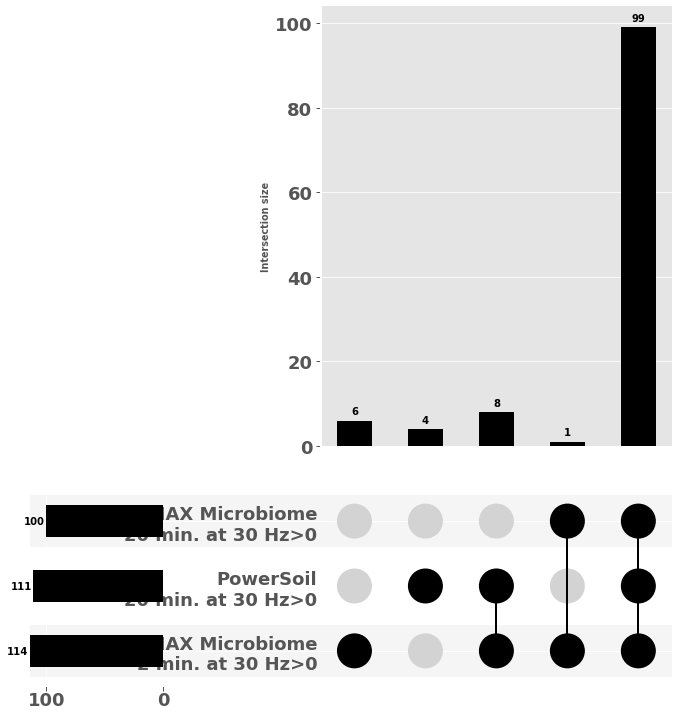

order


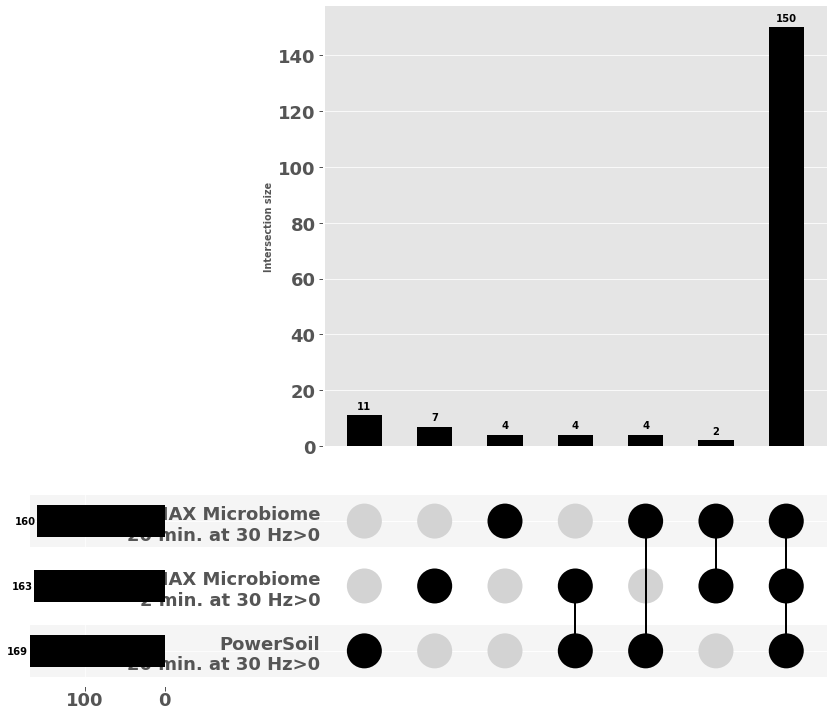

family


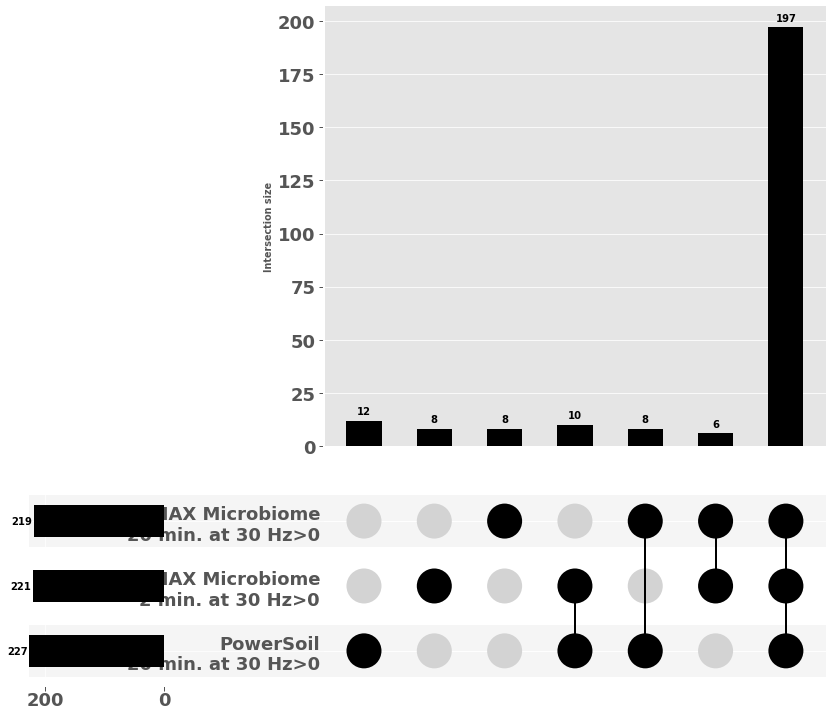

genus


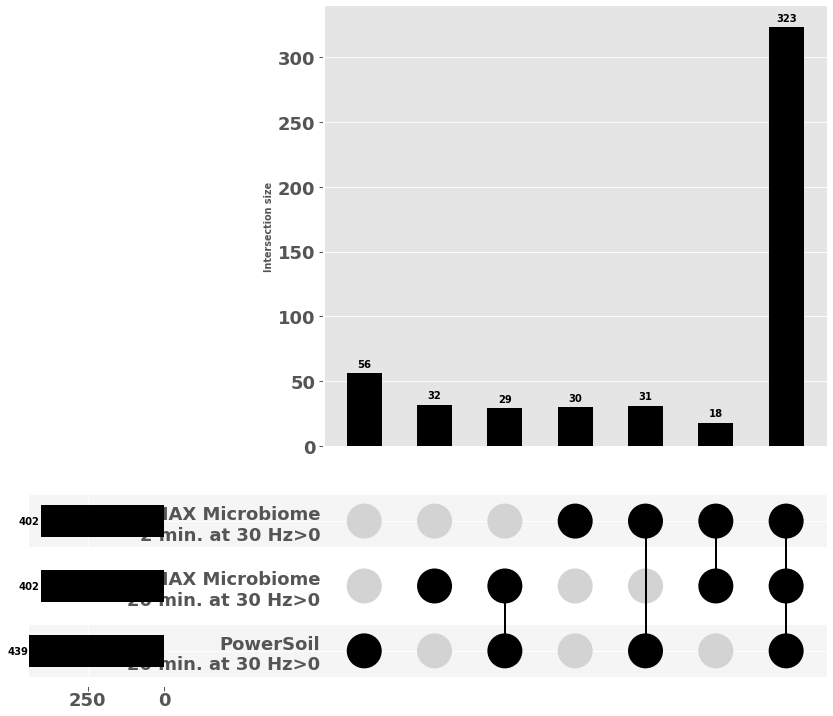

species


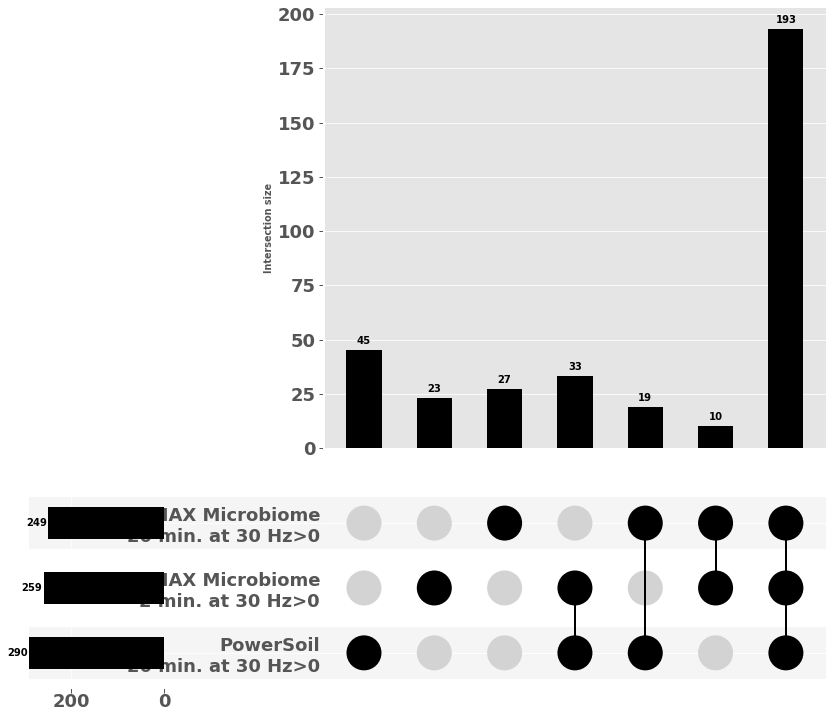

class


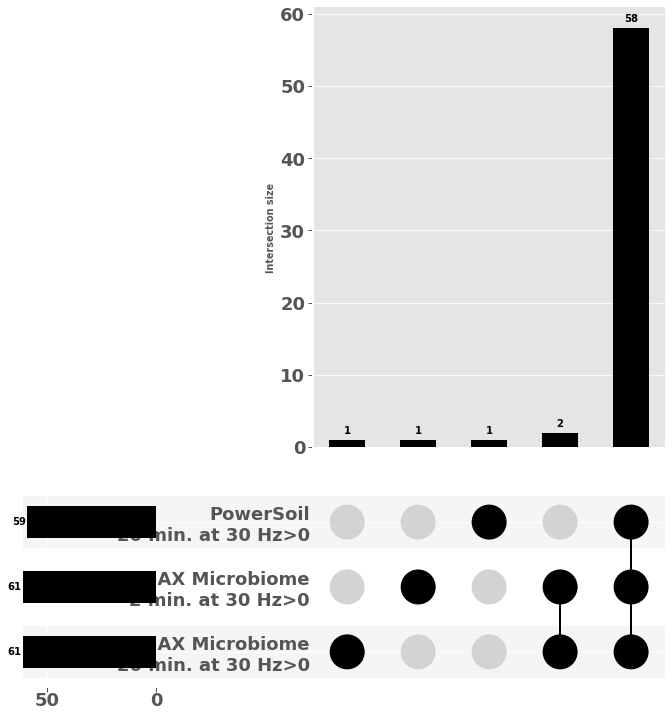

order


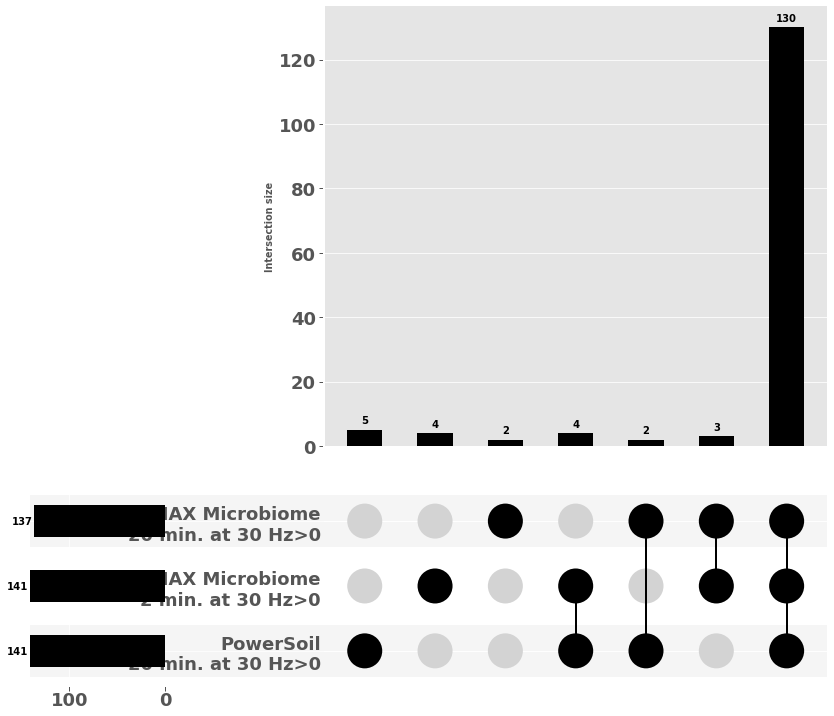

family


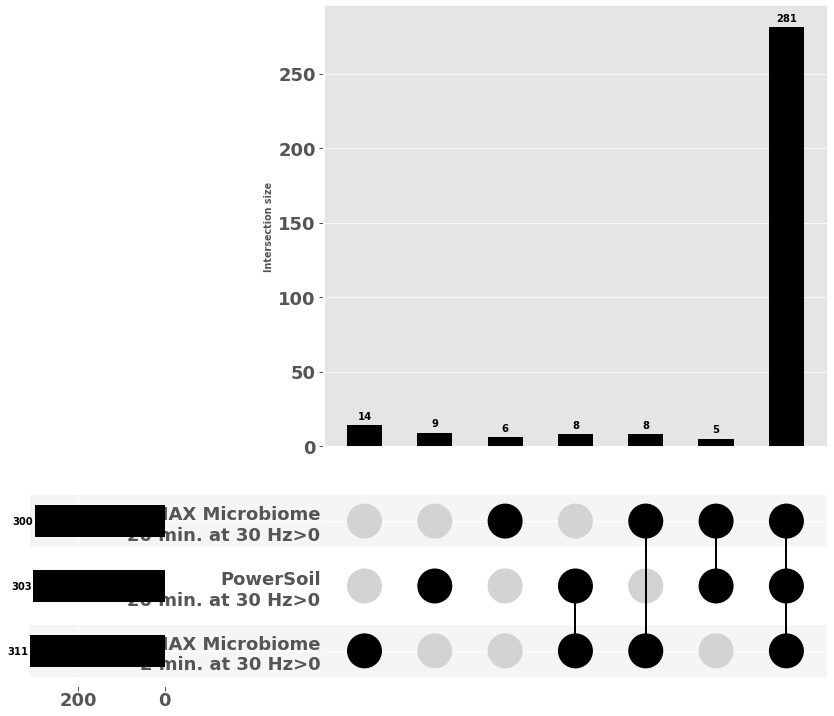

genus


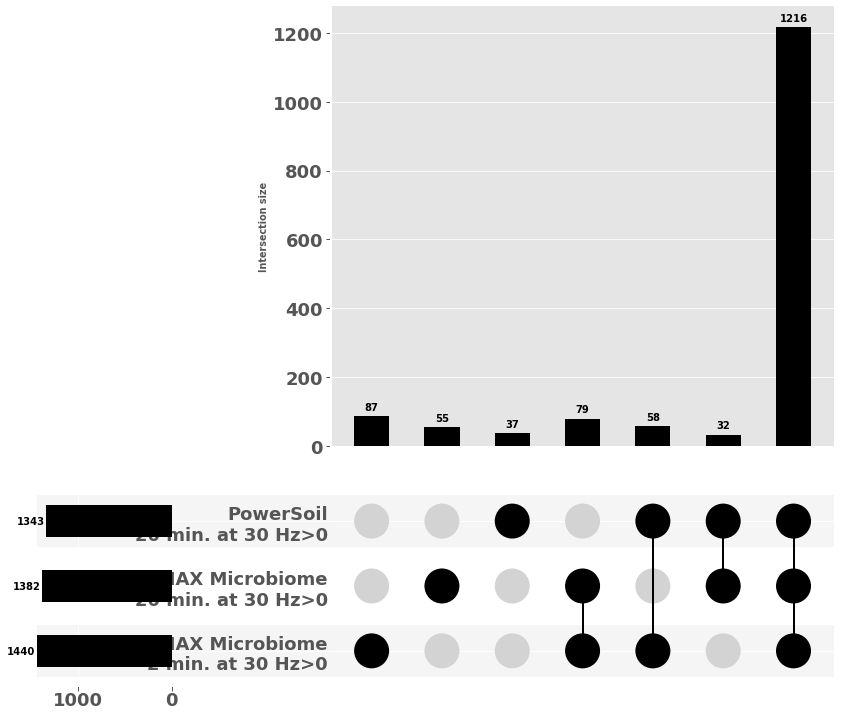

species


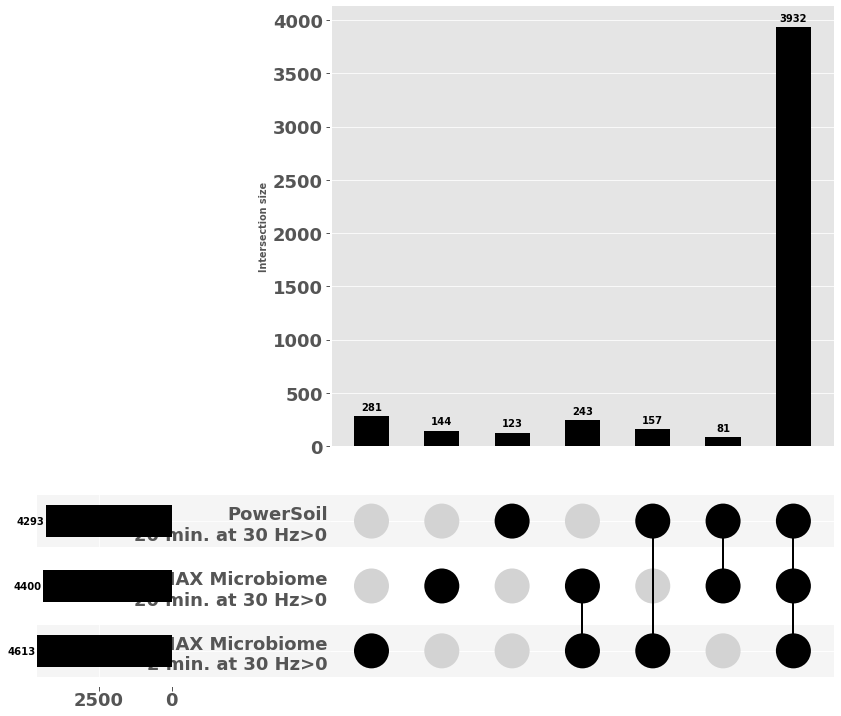

phylum


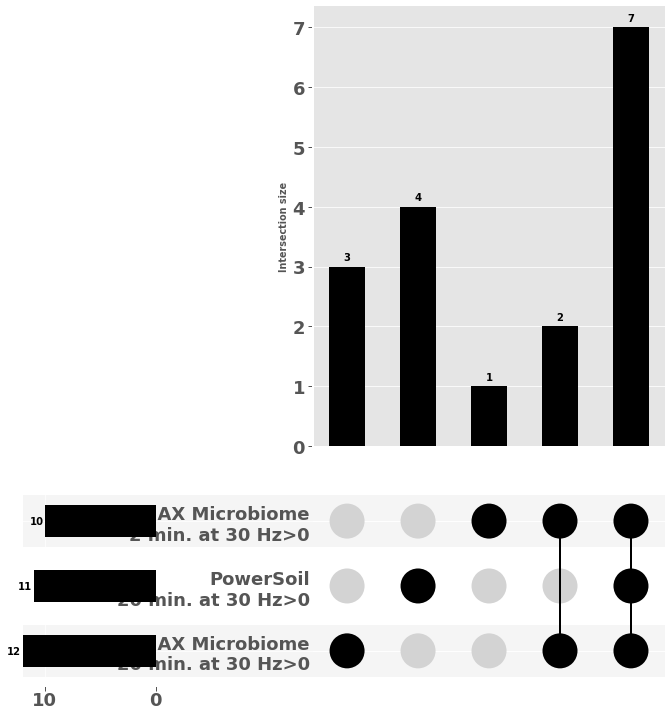

class


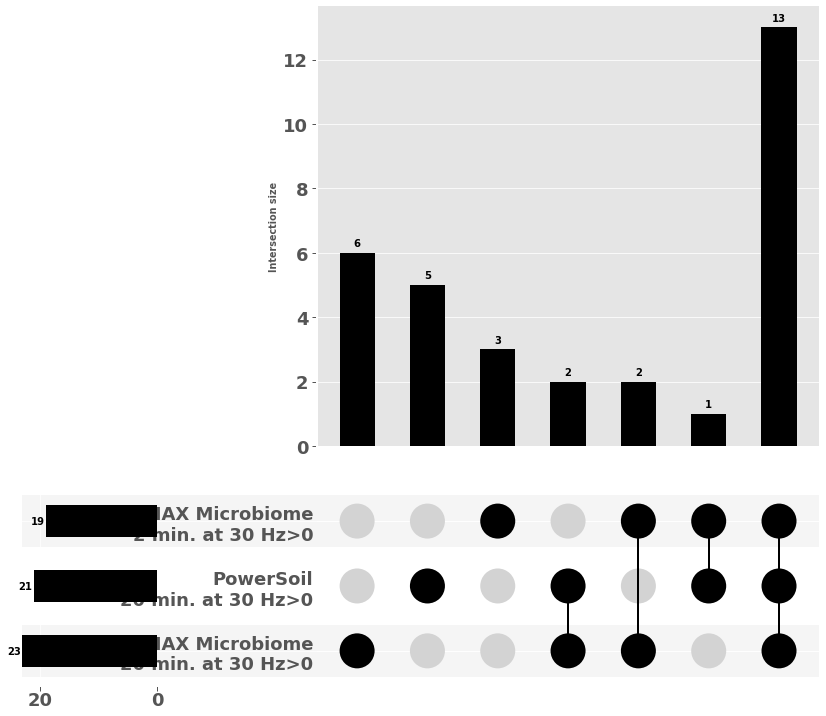

order


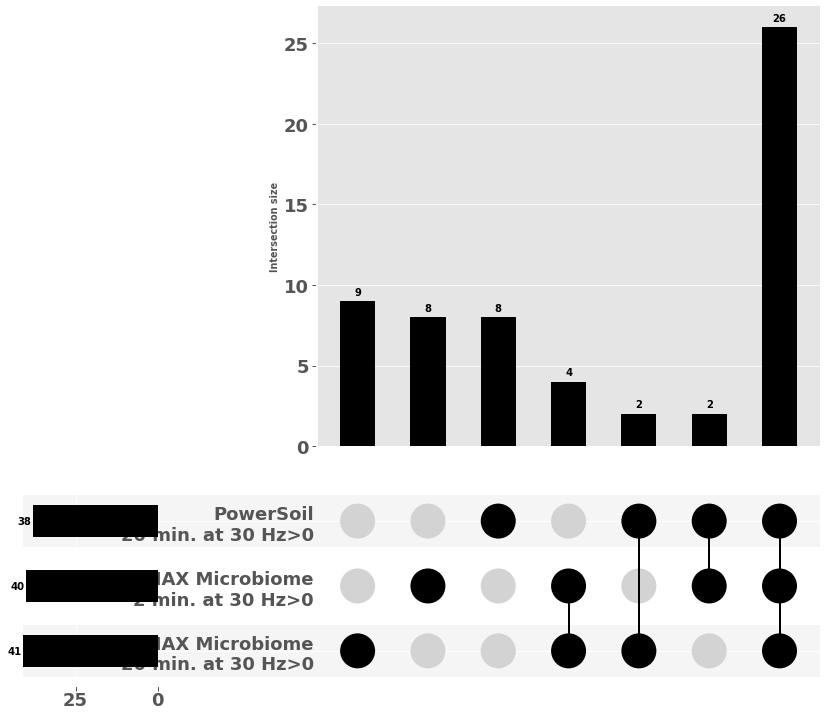

family


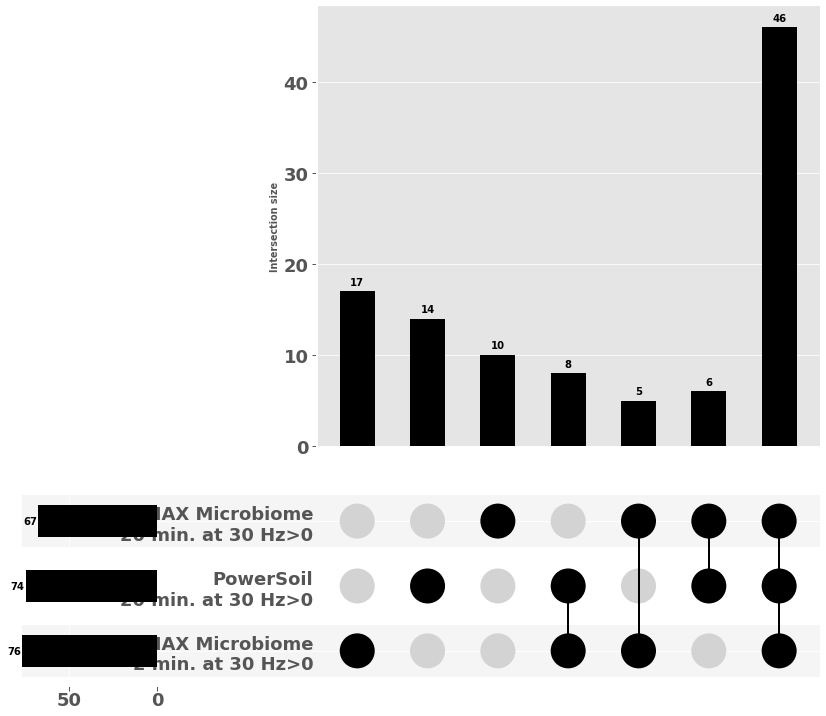

genus


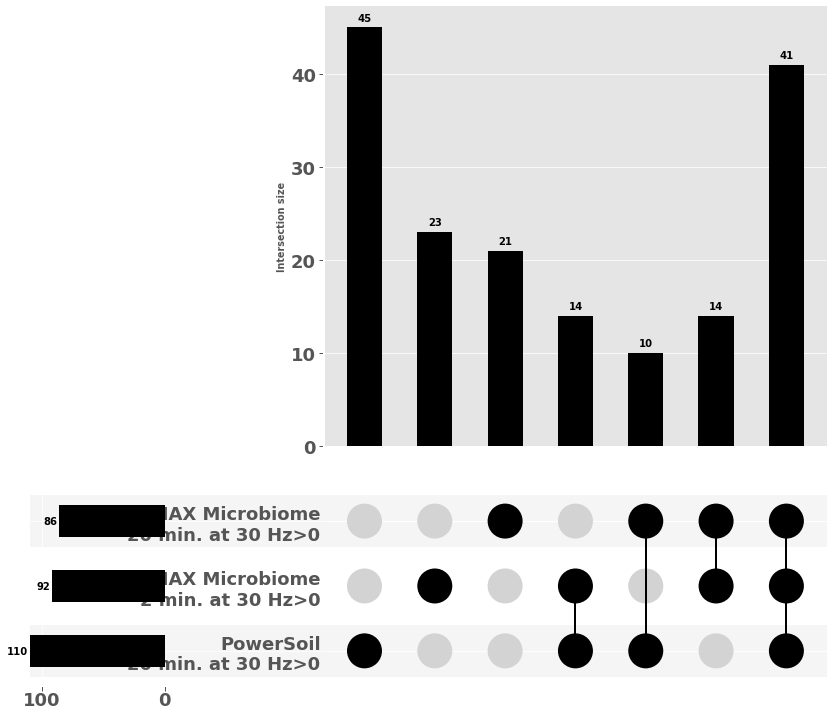

species


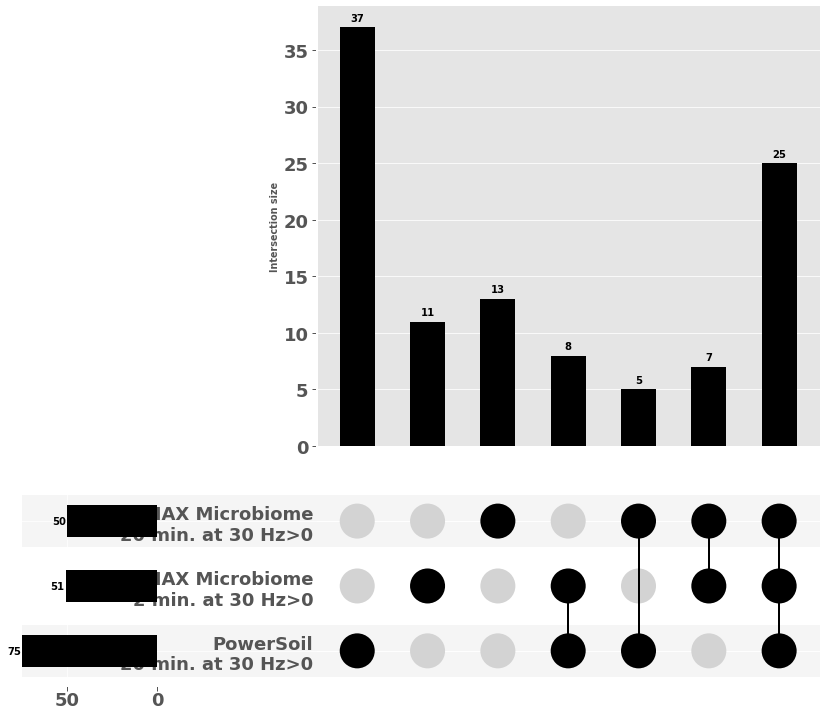

class


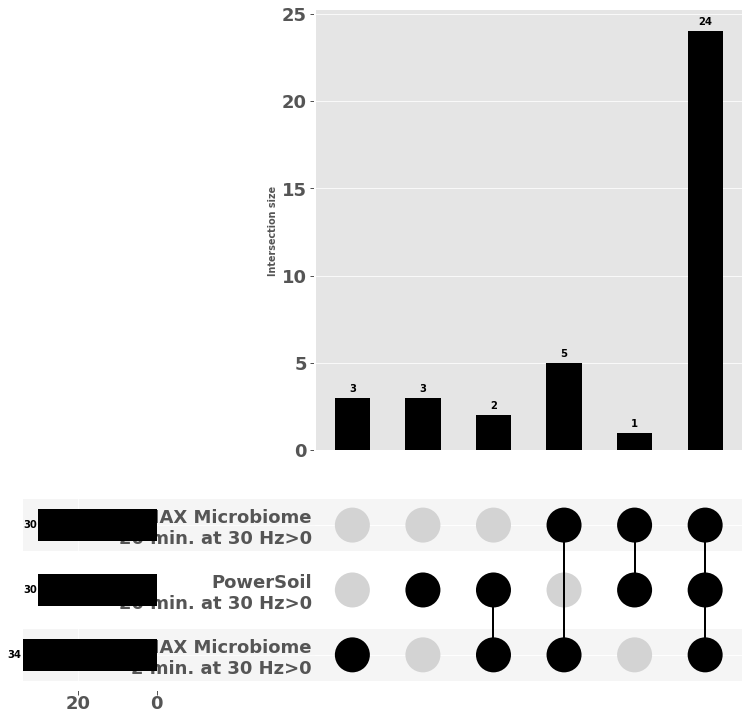

order


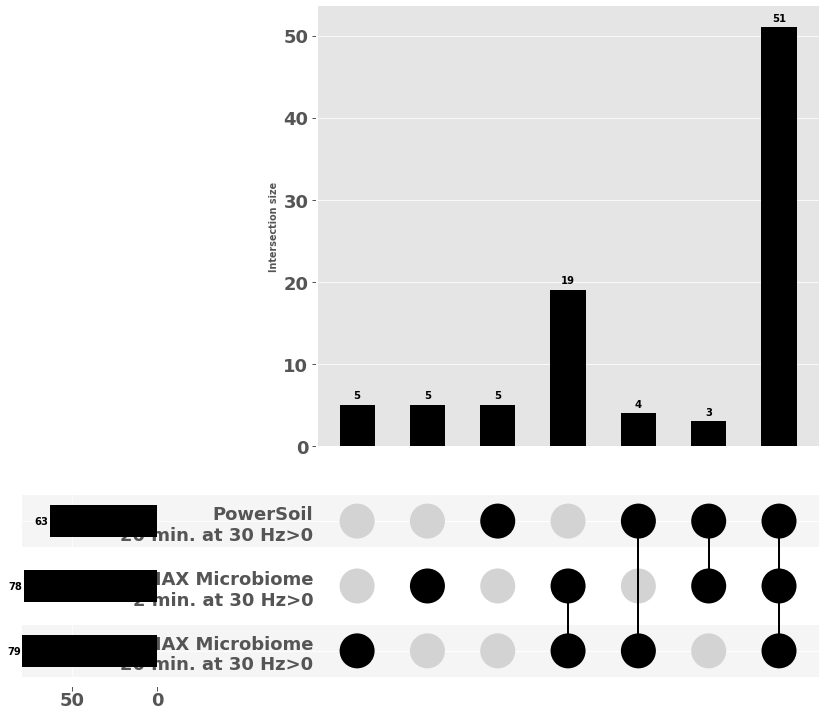

family


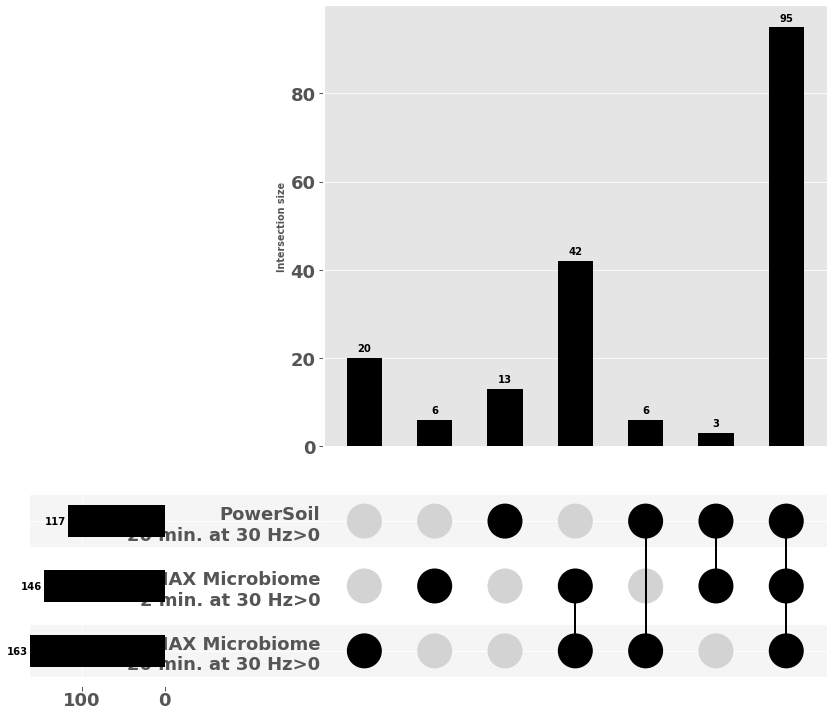

genus


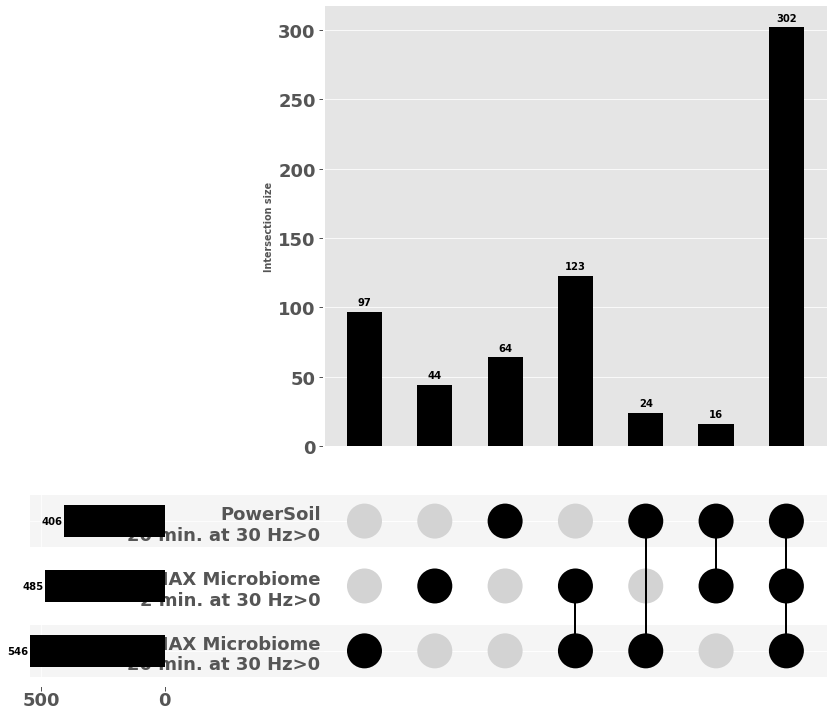

species


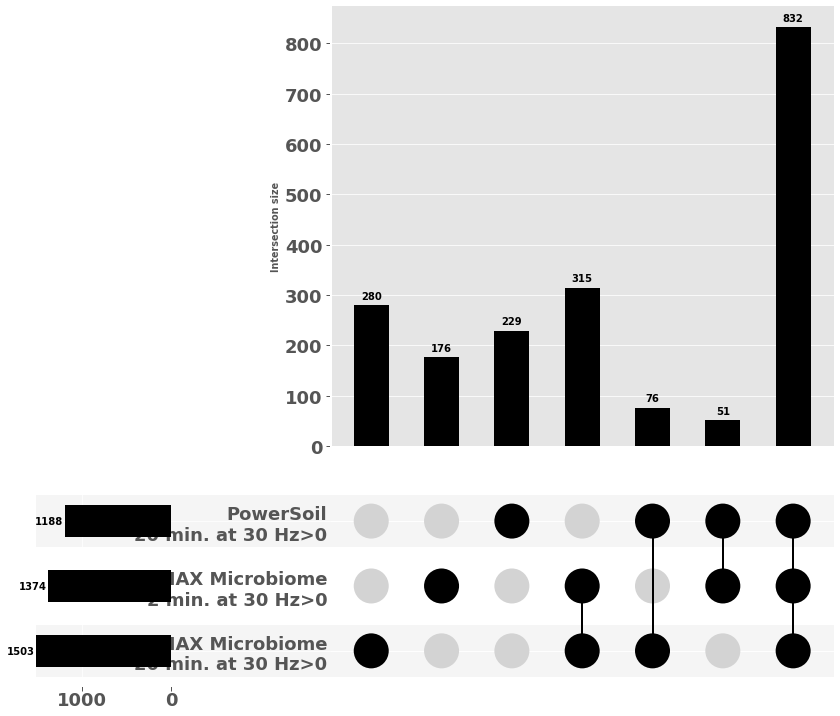

phylum


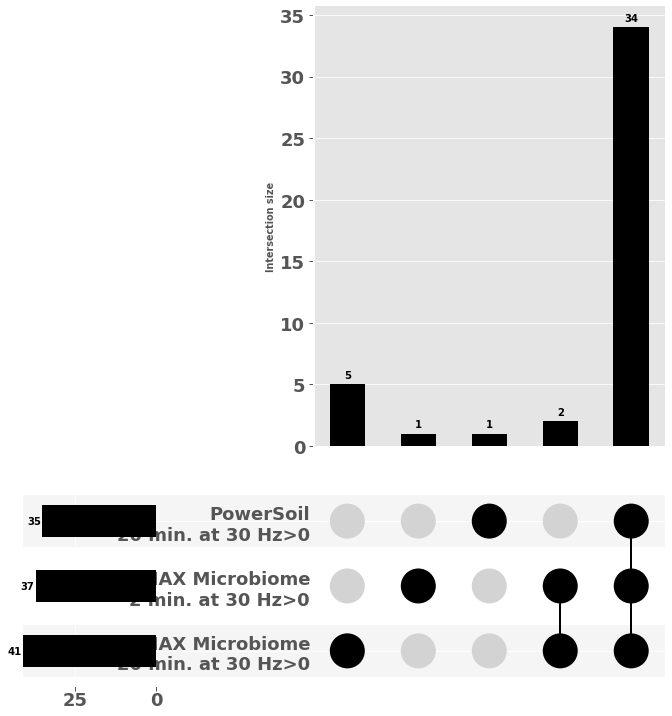

class


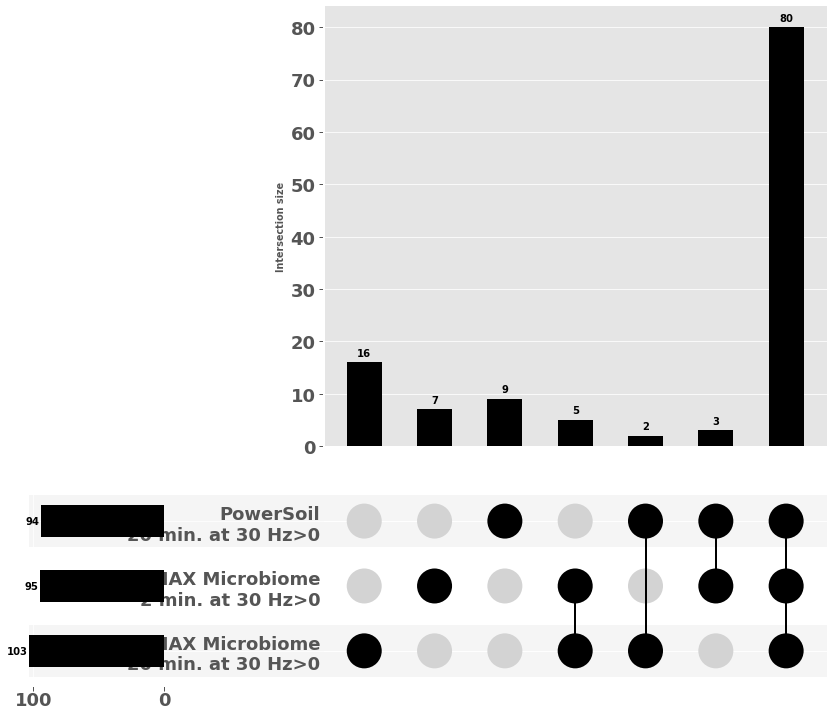

order


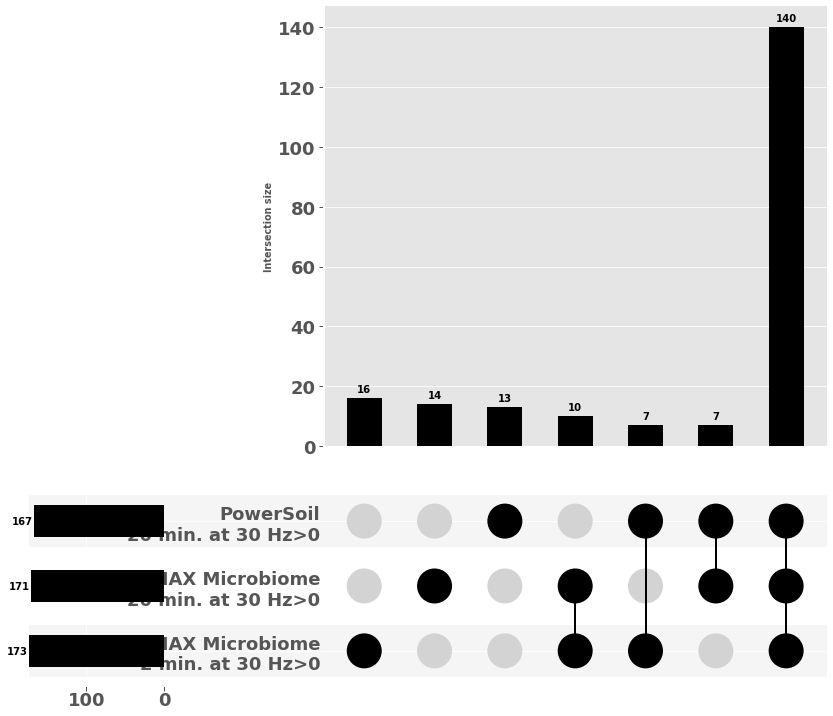

family


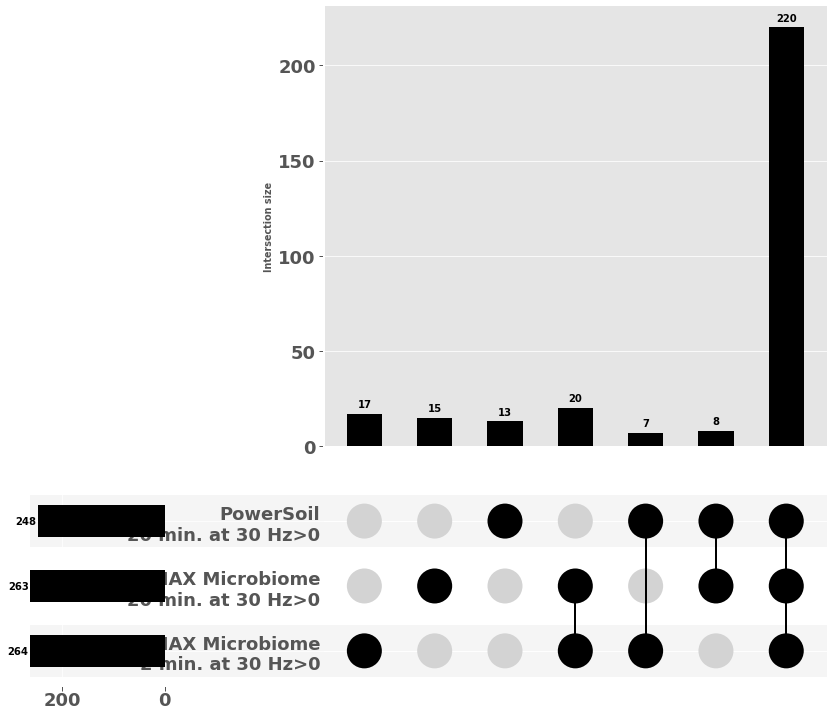

genus


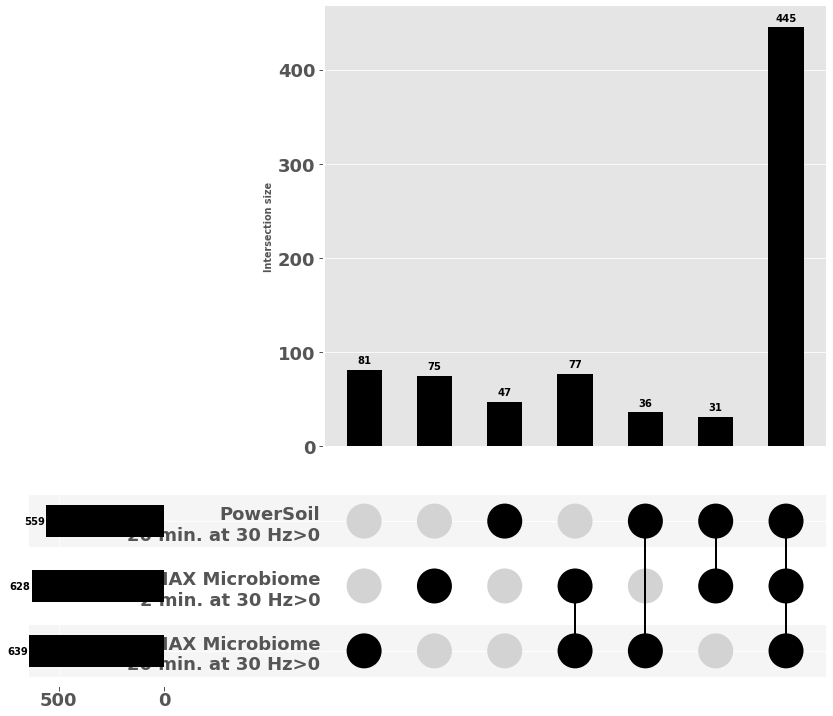

species


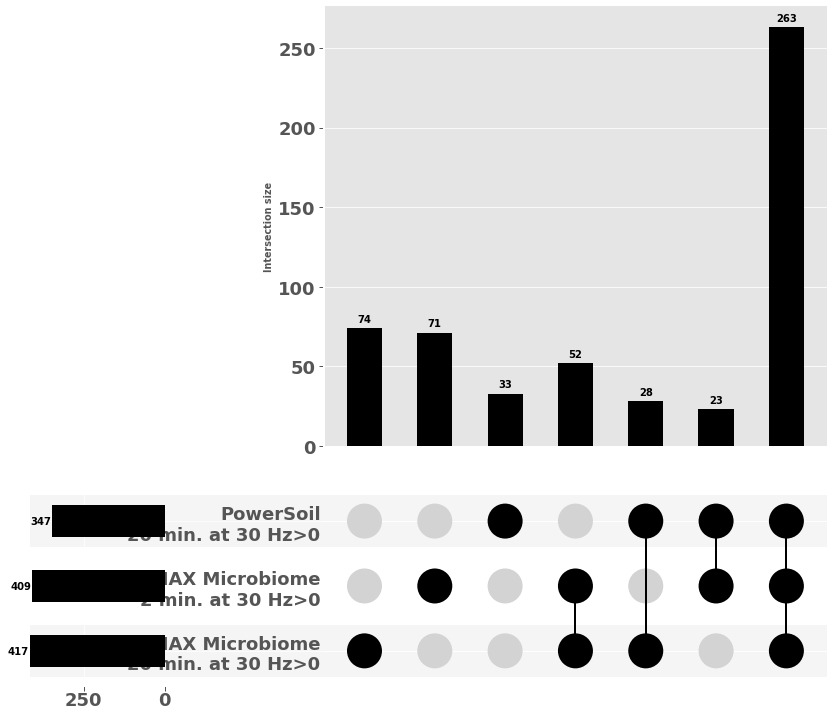

class


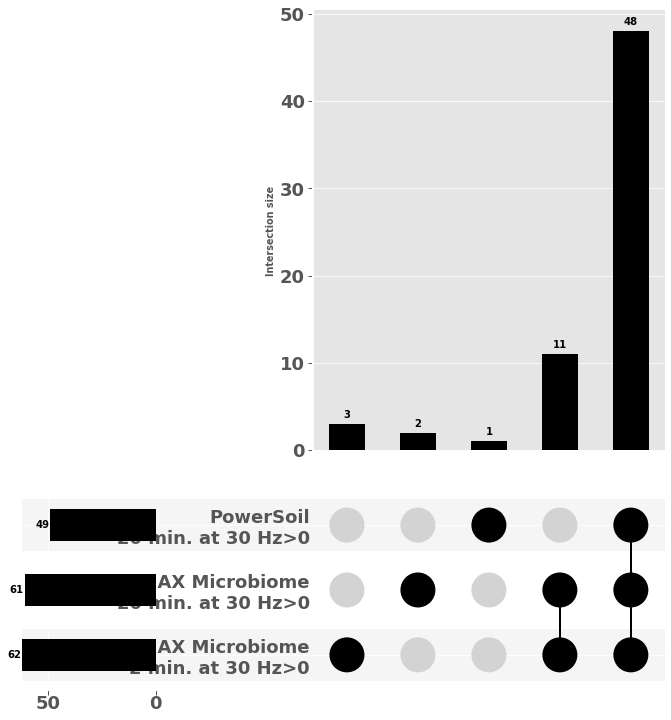

order


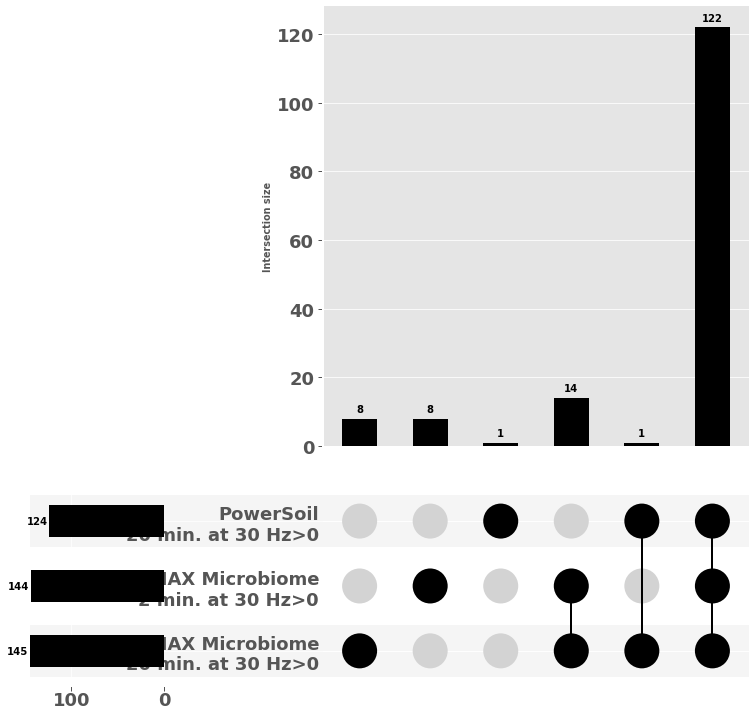

family


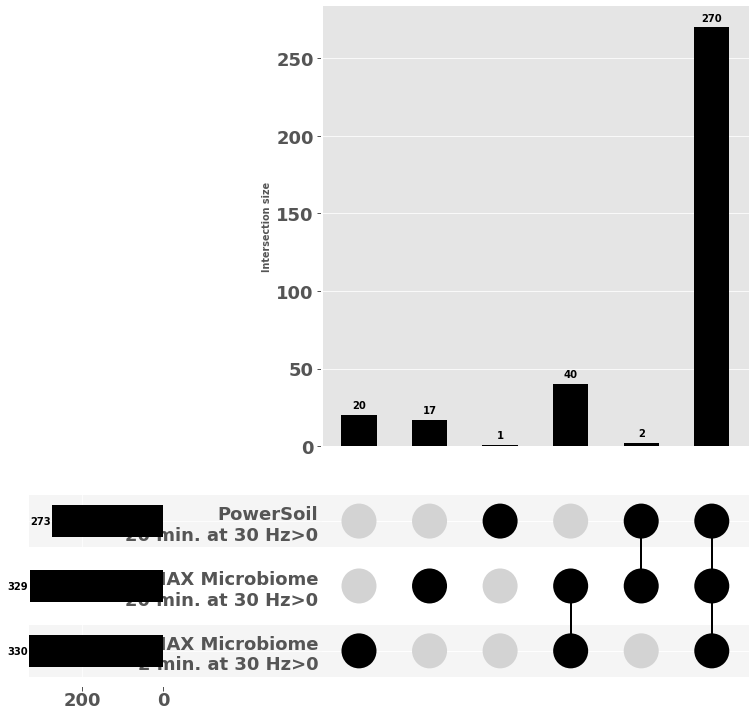

genus


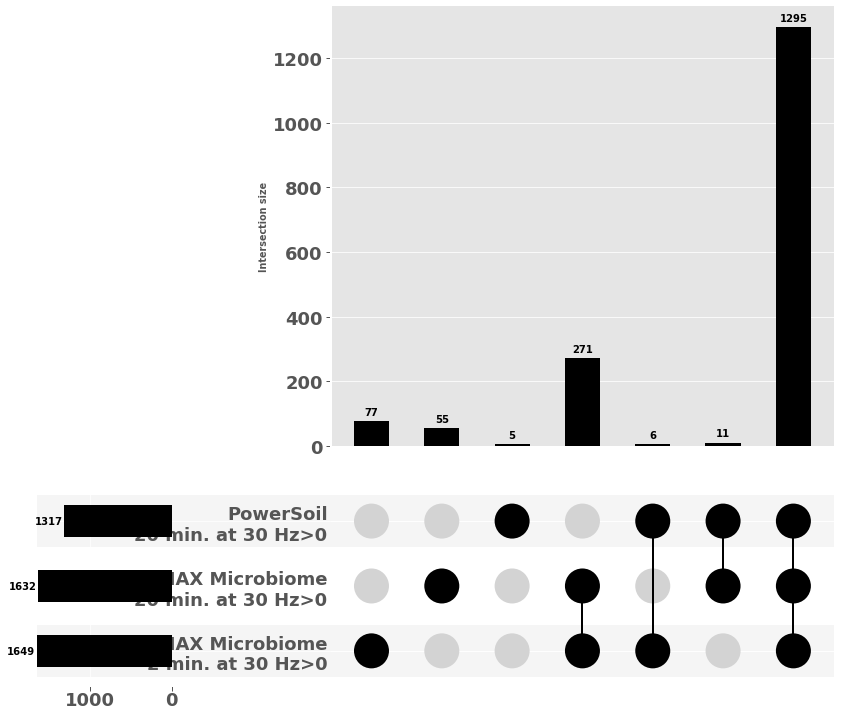

species


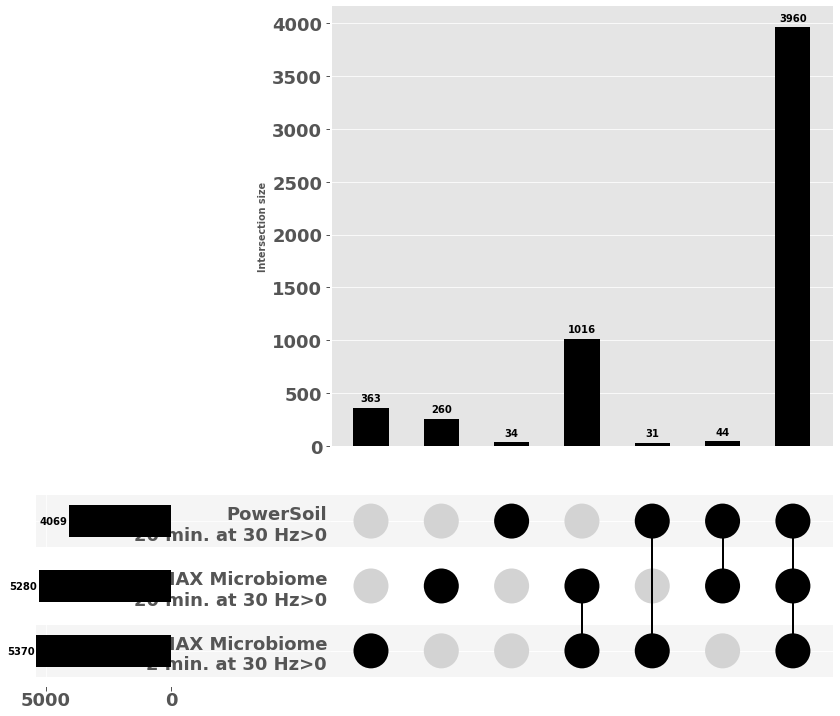

In [54]:
# encode different protocols
protocols = {}
protocols['16S'] = ['../data/%s/extraction_test_round_3_biom_lod.qza' % ('16S'),
                    '../data/%s/metadata_12201_round3_qiitaIDs_2020.08.12_qiime2.txt' % ('16S'),
                    '../data/%s/extraction_test_round3_16S_150bp_deblur_insertion_tree.tre' % ('16S'),
                   '../data/%s/extraction_test_round3_16S_150bp_deblur_taxonomy_gg138_V4.tsv' % ('16S')]
protocols['metagenomic'] = [ '../data/%s/gotu_profile_updated_sampleIDs_min17K.qza' % ('Metagenomic'),
                            '../data/%s/metadata_12201_round3_qiitaIDs_2020.08.17_qiime2.txt' % ('Metagenomic'),
                            '../data/%s/phylogeny.qza' % ('Metagenomic'),
                            '../data/%s/taxonomy.qza' % ('Metagenomic')]
# repeat both protocols
for biomass, biomass_  in {'all':['high', 'low', 'not applicable', 'variable'],
                           'high':['high'],'variable':['variable'], 'low':['low']}.items():
    for protocol, (table, metadata, tree, taxonomy) in protocols.items():
        # import data
        table = q2.Artifact.load(table).view(biom.Table)
        metadata = q2.Metadata.load(metadata).to_dataframe()
        metadata['extraction_kit_bead_beating'] = metadata.extraction_kit + '\n' + metadata.bead_beating
        metadata = metadata[metadata.biomass_sample.isin(biomass_)]
        # match tables
        shared_ = set(table.ids()) & set(metadata.index)
        table = table.filter(shared_)
        metadata = metadata.reindex(shared_)

        if 'qza' not in tree:
            tree = q2.Artifact.import_data('Phylogeny[Rooted]', tree)
        else:
            tree = q2.Artifact.load(tree)

        if 'qza' not in taxonomy:
            taxonomy = q2.Metadata.load(taxonomy).to_dataframe()
        else:
            taxonomy = q2.Artifact.load(taxonomy).view(q2.Metadata).to_dataframe()
        taxonomy = add_taxsplit(taxonomy) # split by taxonomic level
        taxonomy.reindex(table.ids('observation'))

        total_kits = []
        for kit_, mfdf in metadata.groupby('extraction_kit_bead_beating'):
            # get all taxa in kit
            psbt = table.copy()
            psbt = psbt.filter(mfdf.index)
            keep_ = psbt.ids('observation')[psbt.sum('observation') > 0]
            psbt = psbt.filter(keep_, axis='observation')
            psbt = pd.DataFrame(psbt.sum(axis='observation'),
                                psbt.ids('observation'),
                                [kit_])
            total_kits.append(psbt)
        # combine totals
        totaldf = pd.concat(total_kits, axis=1).fillna(0)
        totaldf.head(5)

        # format plotting for each level
        formatted_levels = {}
        for level_ in taxonomy.columns[3:]:
            tax_ = taxonomy.loc[totaldf.index, level_].copy().dropna()
            totaldf_tax = totaldf.loc[tax_.index, :].copy()
            totaldf_tax[level_] = tax_.loc[totaldf_tax.index,]
            totaldf_tax = totaldf_tax.groupby(level_).sum()
            totaldf_tax = format_uplot(totaldf_tax)
            formatted_levels[level_] = totaldf_tax.copy()

        for level_, pltdf_ in formatted_levels.items():
            print(level_)
            # UpSet plot it!
            fig = plt.figure(figsize=(12,10))
            upset = UpSet(pltdf_, subset_size='count',
                          element_size = 100,
                          #facecolor='gray',
                          show_counts=True)
            #upset.add_catplot(value='median_value', kind='strip', color='blue')
            #upset.add_catplot(value='AGE', kind='strip', color='black')
            upset.plot(fig=fig)
            # save the figure to file
            plt.savefig('../results/upset-plots/biomass-%s-protocol-%s-upset-%s.pdf' % (biomass, protocol, level_),dpi=600, 
                        bbox_inches='tight',
                        facecolor=fig.get_facecolor(), 
                        edgecolor='none')

            plt.show()

